# House Prices: Advanced Regression Techniques

Predict sales prices and practice feature engineering, RFs, and gradient boosting

<img src="housesbanner.png"  align="left" style="width: 600px;"/>

<span style="font-family: Courier New; background-color: #ffcc5c; color: #000000; padding: 3px; ">Performed by:</span> Nicolás D'Alessandro & David Zekaria

______

### 00 - Load the required libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

____

### 00 - Create required formulas

In [3]:
def describe(data):
    '''
    This function displays a basic description about the numerical features in the given dataset:
        >>> Parameter 1: [DataFrame] Pandas DataFrame.
        ------------------------------------------------
        <<< Return: Dataset basic description.
    '''
    print('\033[1m' + 'Numerical values description:'+ '\033[0m')
    
    return data.describe().round(2)

def nullvaluesf_count(data):
    '''
    This function displays the features that contains null values as well as the correspondig count:
        >>> Parameter 1: [DataFrame] Pandas DataFrame.
        ------------------------------------------------
        <<< Return: Features with null values and count.
    '''
    print('\033[1m' + 'Top 10 Features with null values:'+ '\033[0m')

    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    missing__train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing__train_data.head(10)
        
    return missing__train_data.head(10)

def categorical_info(data):
    '''
    This function displays name and count of unique values of the categorical features in the given dataset:
        >>> Parameter 1: [DataFrame] Pandas DataFrame.
        ------------------------------------------------
        <<< Return: Categorical features and count uniques
    '''
    print('\033[1m' + 'Categorical features counts:' + '\033[0m')
    
    return data.select_dtypes(include= 'object').apply(lambda x: x.count())


def score_dataset(X_train, X_valid, y_train, y_valid):
    '''
            This function displays the MAE comparing different datasets approaches:
        >>> Parameter 1: [DataFrame] X_train.
        >>> Parameter 2: [DataFrame] X_valid.
        >>> Parameter 3: [DataFrame] y_train.
        >>> Parameter 4: [DataFrame] y_valid.
        ------------------------------------------------
        <<< Return: MAE on top of the given predictions. -
        '''
    model = RandomForestRegressor(n_estimators=100, random_state=0, silent=True)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    
    print('\033[1m' + 'MAE from Imputation:'+ '\033[0m')
    
    return mean_absolute_error(y_valid, preds)

def score_dataset2(X_train, X_valid, y_train, y_valid):
    '''
        This function displays the MAE comparing two different approaches:
        >>> Parameter 1: [DataFrame] X_train
        >>> Parameter 2: [DataFrame] X_valid.
        >>> Parameter 3: [DataFrame] y_train.
        >>> Parameter 4: [DataFrame] y_valid.
        ------------------------------------------------
        <<< Return: MAE on top of the given predictions. -
    '''
    model2 = XGBRegressor(n_estimators=1000, learning_rate=0.05, silent=True)
    model2.fit(X_train, y_train)
    preds2 = model2.predict(X_valid)
    
    print('\033[1m' + 'MAE from Imputation:'+ '\033[0m')
    
    return mean_absolute_error(y_valid, preds2)

def create_boxplot(dataset):
    '''
       This function plot boxplot for each column of the given dataset:
        >>> Parameter 1: [DataFrame] Pandas DataFrame.
        ------------------------------------------------
        <<< Return: Plot.
    
    '''
    fig = plt.figure(figsize=(15,6))
    ax = sns.boxplot(data = dataset)
    plt.xticks(rotation=90)

___

### 01 - Load the given datasets

In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

____

### 02 - Perform EDA on the loaded datasets

In [5]:
describe(df_train)

Numerical values description:


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.00,1460.0,1201.00,1460.00,1460.00,1460.00,1460.00,1460.00,1452.00,1460.00,...,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.0
mean,730.50,56.9,70.05,10516.83,6.10,5.58,1971.27,1984.87,103.69,443.64,...,94.24,46.66,21.95,3.41,15.06,2.76,43.49,6.32,2007.82,180921.2
std,421.61,42.3,24.28,9981.26,1.38,1.11,30.20,20.65,181.07,456.10,...,125.34,66.26,61.12,29.32,55.76,40.18,496.12,2.70,1.33,79442.5
min,1.00,20.0,21.00,1300.00,1.00,1.00,1872.00,1950.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2006.00,34900.0
25%,365.75,20.0,59.00,7553.50,5.00,5.00,1954.00,1967.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,2007.00,129975.0
50%,730.50,50.0,69.00,9478.50,6.00,5.00,1973.00,1994.00,0.00,383.50,...,0.00,25.00,0.00,0.00,0.00,0.00,0.00,6.00,2008.00,163000.0
75%,1095.25,70.0,80.00,11601.50,7.00,6.00,2000.00,2004.00,166.00,712.25,...,168.00,68.00,0.00,0.00,0.00,0.00,0.00,8.00,2009.00,214000.0
max,1460.00,190.0,313.00,215245.00,10.00,9.00,2010.00,2010.00,1600.00,5644.00,...,857.00,547.00,552.00,508.00,480.00,738.00,15500.00,12.00,2010.00,755000.0


In [6]:
categorical_info(df_train).head(10)

Categorical features counts:


MSZoning        1460
Street          1460
Alley             91
LotShape        1460
LandContour     1460
Utilities       1460
LotConfig       1460
LandSlope       1460
Neighborhood    1460
Condition1      1460
dtype: int64

In [7]:
df_nulls = nullvaluesf_count(df_train).transpose()
df_nulls 

Top 10 Features with null values:


,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,LotFrontage,GarageCond,GarageType,GarageYrBlt,GarageFinish
Total,1453.000000,1406.00000,1369.000000,1179.000000,690.000000,259.000000,81.000000,81.000000,81.000000,81.000000
Percent,99.520548,96.30137,93.767123,80.753425,47.260274,17.739726,5.547945,5.547945,5.547945,5.547945


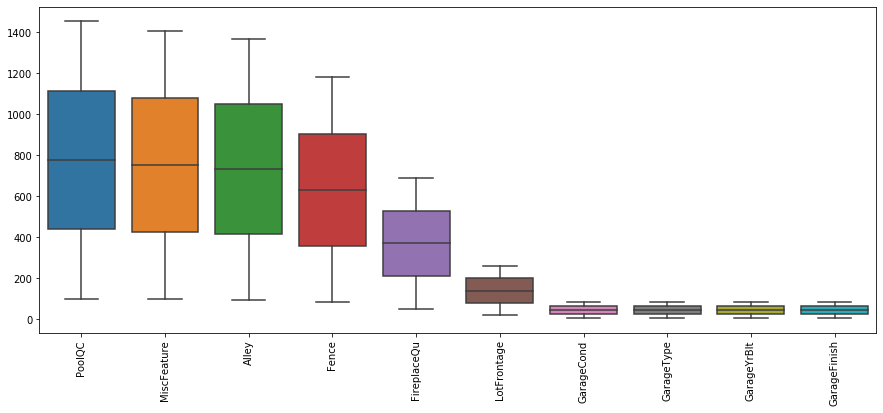

In [8]:
create_boxplot(df_nulls)

____

### 03 - Feature Engineering

#### a - Remove rows & columns

In [9]:
#remove rows with missing target and 
df_train.dropna(axis=0, subset=['SalePrice'], inplace=True)

In [10]:
#separate target from predictors
df_target = df_train['SalePrice']
df_train = df_train.drop(['SalePrice'], axis=1)

In [11]:
#remove columns with null values
df_train.drop(['PoolQC',"MiscFeature","Alley","Fence","FireplaceQu"], axis=1, inplace=True)
df_test.drop(['PoolQC',"MiscFeature","Alley","Fence","FireplaceQu"], axis=1, inplace=True)

#### b - Train test split

In [12]:
#break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(df_train, df_target,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

#### c - Imputations

In [13]:
# Get list of categorical variables
s = (df_train.dtypes == 'object')
object_cols = list(s[s].index)

# Remove categorical columns
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)
num_df_train = df_train.drop(object_cols, axis=1)

# Remove Ids
num_X_train.drop(['Id',"MoSold","YrSold"], axis=1, inplace=True)
num_X_valid.drop(['Id',"MoSold","YrSold"], axis=1, inplace=True)
num_df_train.drop(['Id',"MoSold","YrSold"], axis=1, inplace=True)

# Imputation
my_imputer = SimpleImputer(strategy="constant",fill_value=0)
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(num_X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(num_X_valid))
imputed_df_train = pd.DataFrame(my_imputer.transform(num_df_train))

# Imputation removed column names; put them back
imputed_X_train.columns = num_X_train.columns
imputed_X_valid.columns = num_X_valid.columns
imputed_df_train.columns = num_df_train.columns

In [14]:
score_dataset2(imputed_X_train, imputed_X_valid, y_train, y_valid).round(2)

MAE from Imputation:


16584.83

In [15]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

# Get list of numerical variables
s = (X_train.dtypes != 'object')
num_cols = list(s[s].index)

# Remove numerical columns
cat_X_train = X_train.drop(num_cols, axis=1)
cat_X_valid = X_valid.drop(num_cols, axis=1)
cat_df_train = df_train.drop(num_cols, axis=1)

# Imputation
my_imputer = SimpleImputer(strategy="constant",fill_value="non")
imputed_cat_X_train = pd.DataFrame(my_imputer.fit_transform(cat_X_train))
imputed_cat_X_valid = pd.DataFrame(my_imputer.transform(cat_X_valid))
imputed_cat_df_train = pd.DataFrame(my_imputer.transform(cat_df_train))

# Imputation removed column names; put them back
imputed_cat_X_train.columns = cat_X_train.columns
imputed_cat_X_valid.columns = cat_X_valid.columns
imputed_cat_df_train.columns = cat_df_train.columns

In [16]:
# Columns that will be one-hot encoded
low_cardinality_cols = [col for col in object_cols if imputed_cat_X_train[col].nunique() < 10]

print('\033[1m' + 'Categorical columns that will be one-hot encoded:\n\n'+ '\033[0m', low_cardinality_cols)

Categorical columns that will be one-hot encoded:

 ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


In [17]:
# Columns that will be dropped from the dataset
high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))

print('\033[1m' + 'Categorical columns that will be dropped from the dataset:\n\n' + '\033[0m', high_cardinality_cols)

Categorical columns that will be dropped from the dataset:

 ['Exterior2nd', 'Neighborhood', 'Exterior1st']


#### e - encoding

In [18]:
# Label encode high cardinality
label_X_train = imputed_cat_X_train.copy()
label_X_valid = imputed_cat_X_valid.copy()
label_df_train = imputed_cat_df_train.copy()
XXXX = pd.concat([imputed_cat_X_train, imputed_cat_df_train], ignore_index=True)

# Apply label encoder to each column with categorical data

label_encoder = LabelEncoder()
for col in high_cardinality_cols:
    XXXX[col] = label_encoder.fit_transform(XXXX[col])
    label_X_train[col] = label_encoder.transform(imputed_cat_X_train[col])
    label_X_valid[col] = label_encoder.transform(imputed_cat_X_valid[col])
    label_df_train[col] = label_encoder.transform(imputed_cat_df_train[col])
    
    # Get list of categorical variables
s = (label_X_train.dtypes == 'object')
object_cols = list(s[s].index)

# Apply one-hot encoder to each column with low cardinality categorical data, drop rest

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(imputed_cat_X_train[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(imputed_cat_X_valid[low_cardinality_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(imputed_cat_df_train[low_cardinality_cols]))

# Add one-hot encoded columns to numerical imputed features
OH_X_train = pd.concat([imputed_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([imputed_X_valid, OH_cols_valid], axis=1)
OH_df_train = pd.concat([imputed_df_train, OH_cols_test], axis=1)

In [19]:
OH_X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,175,176,177,178,179,180,181,182,183,184
0,20.0,90.0,11694.0,9.0,5.0,2007.0,2007.0,452.0,48.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,20.0,60.0,6600.0,5.0,5.0,1962.0,1962.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,30.0,80.0,13360.0,5.0,7.0,1921.0,2006.0,0.0,713.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,20.0,0.0,13265.0,8.0,5.0,2002.0,2002.0,148.0,1218.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,20.0,118.0,13704.0,7.0,5.0,2001.0,2002.0,150.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
score_dataset2(OH_X_train, OH_X_valid, y_train, y_valid).round(2)

MAE from Imputation:


15892.83

_____

### 04 - Create & Evaluate Models

In [21]:
#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(OH_X_train,y_train)

clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(OH_X_train,y_train)
importances = clr_rf_5.feature_importances_

std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

In [22]:
#print and plot the feature importance top 15 ranking

def feature_imp_rank(data):
    feature_importance = {}
    for f in range(data.shape[1]):
        feature_importance["feature_%d" % (indices[f])] = importances[indices[f]].round(6)
    
    df = pd.DataFrame([[key, feature_importance[key]] for key in feature_importance.keys()],
                      columns=['feature', 'importance'])
    
    f_i = df.head(15)

    print('\033[1m' + 'Feature ranking:\n\n' + '\033[0m')
    
    plt.figure(figsize=(10, 4))
    plt.title("Feature Importances", fontsize = 15)
    sns.barplot(f_i['feature'], f_i['importance'])
    plt.xticks(rotation=90)
    
    display(f_i)

    return plt.show()

Feature ranking:




,feature,importance
0,feature_15,0.032945
1,feature_2,0.032797
2,feature_12,0.032712
3,feature_11,0.032293
4,feature_10,0.031816
5,feature_26,0.031259
6,feature_5,0.028268
7,feature_24,0.028115
8,feature_1,0.027806
9,feature_6,0.026604


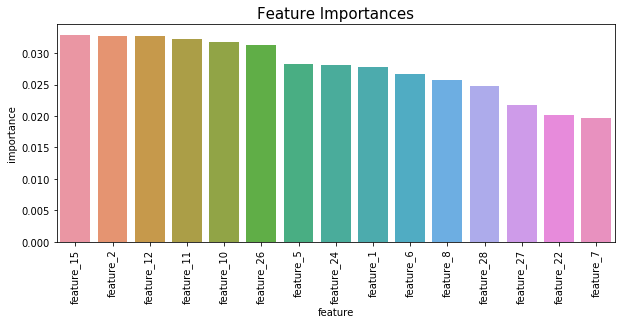

In [23]:
feature_imp_rank(OH_X_train)

In [24]:
# find best scored 11 features
select_feature = SelectKBest(chi2, k=11).fit(OH_X_train, y_train)

####  find low importance features

In [25]:
#selection 1
selectedfeatures1=[]
for i in range(219):
    if (select_feature.scores_[i]>1.000e+05):
        selectedfeatures1.append(OH_X_train.columns[i])
        
print('\033[1m' + 'Selected Features:\n\n'+ '\033[0m', selectedfeatures1)

# drop low importance features
X_TrainSelected1=OH_X_train[selectedfeatures1]
X_ValidSelected1=OH_X_valid[selectedfeatures1]

Selected Features:

 ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'WoodDeckSF', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


In [26]:
score_dataset2(X_TrainSelected1, X_ValidSelected1, y_train, y_valid)

MAE from Imputation:


28415.536065924658

In [27]:
#selection 2
selectedfeatures2=[]
for i in range(219):
    if (importances[i]>0.01):
        selectedfeatures2.append(OH_X_train.columns[i])

print('\033[1m' + 'Selected Features:\n\n'+ '\033[0m', selectedfeatures2)

# drop low importance features
X_TrainSelected2=OH_X_train[selectedfeatures2]
X_ValidSelected2=OH_X_valid[selectedfeatures2]

Selected Features:

 ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF']


In [28]:
score_dataset2(X_TrainSelected2, X_ValidSelected2, y_train, y_valid)

MAE from Imputation:


17442.773504387842

In [29]:
score_dataset2(OH_X_train, OH_X_valid, y_train, y_valid)

MAE from Imputation:


15892.828633347603

In [54]:
selectedfeaturesX=[]
MAEX=[]
BestMAEX=999999
bestfeatures=[]

for i in range(219):
    selectedfeaturesX.append(OH_X_train.columns[indices[i]])
    # drop low importance features
    X_TrainSelectedX=OH_X_train[selectedfeaturesX]
    X_ValidSelectedX=OH_X_valid[selectedfeaturesX]
    modelX = XGBRegressor(n_estimators=1000, learning_rate=0.05)
    modelX.fit(X_TrainSelectedX, y_train)
    predsX = modelX.predict(X_ValidSelectedX)
    MAEX.append(mean_absolute_error(y_valid, predsX))
    if mean_absolute_error(y_valid, predsX)<BestMAEX:
        BestMAEX=mean_absolute_error(y_valid, predsX)
        bestfeatures=selectedfeaturesX

[15:07:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:07:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:07:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:07:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:07:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:07:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:07:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:07:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:07:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[15:10:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:10:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:10:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:10:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:10:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:10:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:10:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:10:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:10:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[15:57:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:58:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:58:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:58:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:58:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:58:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:58:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:58:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:58:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[18:14:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:14:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:14:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:14:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:15:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:15:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [55]:
print('\033[1m' + 'Selected Features:\n\n'+ '\033[0m', bestfeatures)

Selected Features:

 ['GrLivArea', 'LotArea', '1stFlrSF', 'TotalBsmtSF', 'BsmtUnfSF', 'GarageArea', 'YearBuilt', 'GarageYrBlt', 'LotFrontage', 'YearRemodAdd', 'BsmtFinSF1', 'OpenPorchSF', 'WoodDeckSF', 'TotRmsAbvGrd', 'MasVnrArea', '2ndFlrSF', 'OverallQual', 'OverallCond', 'BedroomAbvGr', 'MSSubClass', 'Fireplaces', 'BsmtFullBath', 'EnclosedPorch', 'GarageCars', 99, 21, 10, 7, 152, 17, 'HalfBath', 'BsmtFinSF2', 103, 'ScreenPorch', 67, 121, 106, 151, 54, 145, 'FullBath', 68, 153, 125, 56, 123, 81, 96, 137, 88, 136, 149, 47, 101, 183, 50, 3, 82, 27, 89, 98, 74, 73, 102, 97, 77, 79, 113, 94, 178, 69, 105, 40, 4, 179, 14, 'MiscVal', 18, 'BsmtHalfBath', 45, 26, 132, 86, 92, 44, 19, 147, 104, 80, 184, 22, 128, 111, 1, 176, 134, 167, 169, 159, '3SsnPorch', 52, 12, 143, 170, 23, 8, 165, 122, 112, 126, 25, 91, 11, 109, 43, 'LowQualFinSF', 127, 31, 'KitchenAbvGr', 156, 135, 141, 29, 140, 160, 51, 168, 42, 87, 138, 13, 116, 150, 162, 46, 2, 108, 41, 76, 71, 182, 59, 129, 30, 154, 146, 166, 66, 70

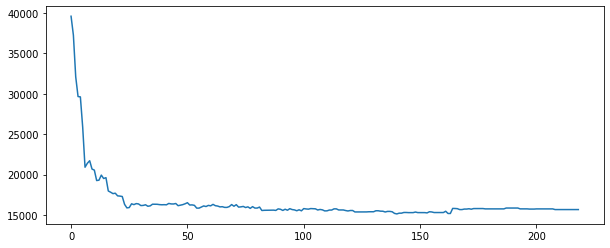

In [56]:
#plot MAEX
fig = plt.figure(figsize=(10,4))
plt.plot(MAEX)
plt.show()

In [57]:
# drop low importance features
X_TrainSelected5=OH_X_train[bestfeatures]
X_ValidSelected5=OH_X_valid[bestfeatures]
OH_X_testSelected=OH_df_train[bestfeatures]

#### Set the final model with the BestFeatures founded

In [58]:
modelfin = XGBRegressor(n_estimators=1000, learning_rate=0.05)
modelfin.fit(X_TrainSelected5, y_train)
predsfin = modelfin.predict(X_ValidSelected5)

[18:17:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [59]:
score_dataset2(X_TrainSelected5, X_ValidSelected5, y_train, y_valid)

MAE from Imputation:


15678.635488013699

#### Save predictions in format used for competition scoring

In [87]:
#save predictions in format used for competition scoring

test_preds = modelfin.predict(OH_X_testSelected)

output = pd.DataFrame({'Id': df_train.Id, 'SalePrice': test_preds})

output.to_csv('submission.csv', index=False)

____